# Bitcoin price prediction using RNN (LSTM) 


EAI / 14.12.2020




# Import libraries

In [1]:
#importing the libraries

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Activation
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

from keras.utils import plot_model

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import io
%matplotlib inline


Specify the TensorFlow version

In [2]:
# %tensorflow_version 2.x
# import tensorflow as tf
print("Tensorflow version is: ", tf.__version__)

Tensorflow version is:  2.11.0


# Load data

Dataset comes from Yahoo! Finance

https://finance.yahoo.com/quote/BTC-USD/history?period1=1279314000&period2=1556053200&interval=1d&filter=history&frequency=1d 

In [3]:
# ## take data using ount drive solution
# from google.colab import drive  # mount gdrive to acces data
# drive.mount('/gdrive')
# %cd /gdrive
# btc = pd.read_csv('/gdrive/My Drive/Colab Notebooks/Data_files/btc_new.csv') # read data 

## Download data from the Google drive
# We are using here some useful commands from the GNU Core Utilities for Unix environments
!wget -O btc_usd.csv 'https://drive.google.com/uc?export=download&id=1xU3lQ2x0VkrvKhZr_loEGhxHe1k2hWLt'  
btc = pd.read_csv('btc_usd.csv')


--2023-02-24 02:33:00--  https://drive.google.com/uc?export=download&id=1xU3lQ2x0VkrvKhZr_loEGhxHe1k2hWLt
Resolving drive.google.com (drive.google.com)... 74.125.68.139, 74.125.68.101, 74.125.68.102, ...
Connecting to drive.google.com (drive.google.com)|74.125.68.139|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-14-8c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/5k2972e5lnho69qau0thp29ggtsi5dr5/1677205950000/07633083979346345059/*/1xU3lQ2x0VkrvKhZr_loEGhxHe1k2hWLt?e=download&uuid=fe591785-1a55-4ac6-87ac-171f123f9109 [following]
--2023-02-24 02:33:01--  https://doc-14-8c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/5k2972e5lnho69qau0thp29ggtsi5dr5/1677205950000/07633083979346345059/*/1xU3lQ2x0VkrvKhZr_loEGhxHe1k2hWLt?e=download&uuid=fe591785-1a55-4ac6-87ac-171f123f9109
Resolving doc-14-8c-docs.googleusercontent.com (doc-14-8c-docs.googleusercontent.com)... 74.125.200.132, 2404:6800

# Explore and preprocess data

## View dataset

The dataset:  
 [  781.481018   778.088013   784.906982 ... 18803.65625  19142.382813
 19188.367188]

The size of the dataset is:  1462


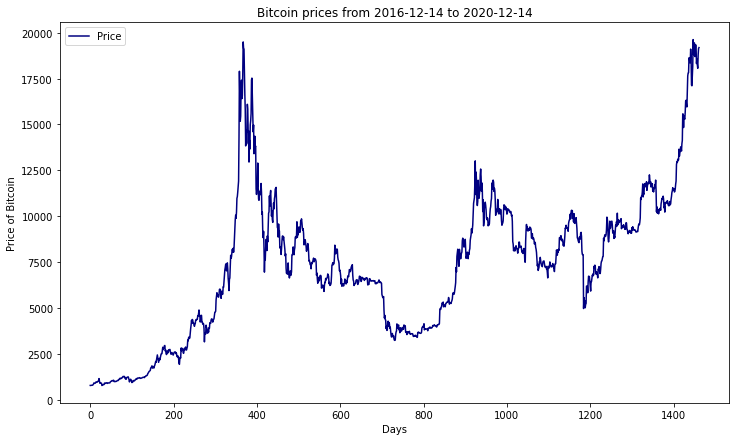

max:  19625.835938   min: 777.757019  mean:  7245.143068168262


In [4]:
# How the original .csv dataset look like?
btc.head(btc.shape[0])  # returns some first and last rows 

#select only the column that we are going to use in the prediction process
dataset = btc['Close'].values
print('The dataset:  \n', dataset)
m = dataset.shape[0]
print("\nThe size of the dataset is: ", m)
plt.figure(figsize=(12,7))
title = "Bitcoin prices from " + str(btc['Date'][0]) + " to " + str(btc["Date"][m-1])
plt.title(title)
plt.xlabel('Days')
plt.ylabel('Price of Bitcoin')
plt.plot(dataset, color ='navy', label='Price')
plt.legend()
plt.show()
print("max: ", max(dataset), '  min:', min(dataset), ' mean: ', np.mean(dataset))

## Standardize features
Standardize features by removing the mean and scaling to unit variance.
The standard score of a sample x is calculated as:

z = (x - u) / s

where u is the mean of the training samples or zero if with_mean=False, and s is the standard deviation of the training samples or one if with_std=False.

Centering and scaling happen independently on each feature by computing the relevant statistics on the samples in the training set. Mean and standard deviation are then stored to be used on later data using transform.

Standardization of a dataset is a common requirement for many machine learning estimators: they might behave badly if the individual features do not more or less look like standard normally distributed data (e.g. Gaussian with 0 mean and unit variance).


The standardized dataset:  
 [[-1.65229279]
 [-1.65316014]
 [-1.65141702]
 ...
 [ 2.95467923]
 [ 3.04126721]
 [ 3.0530221 ]]

The size of the standardized dataset is:  (1462, 1)


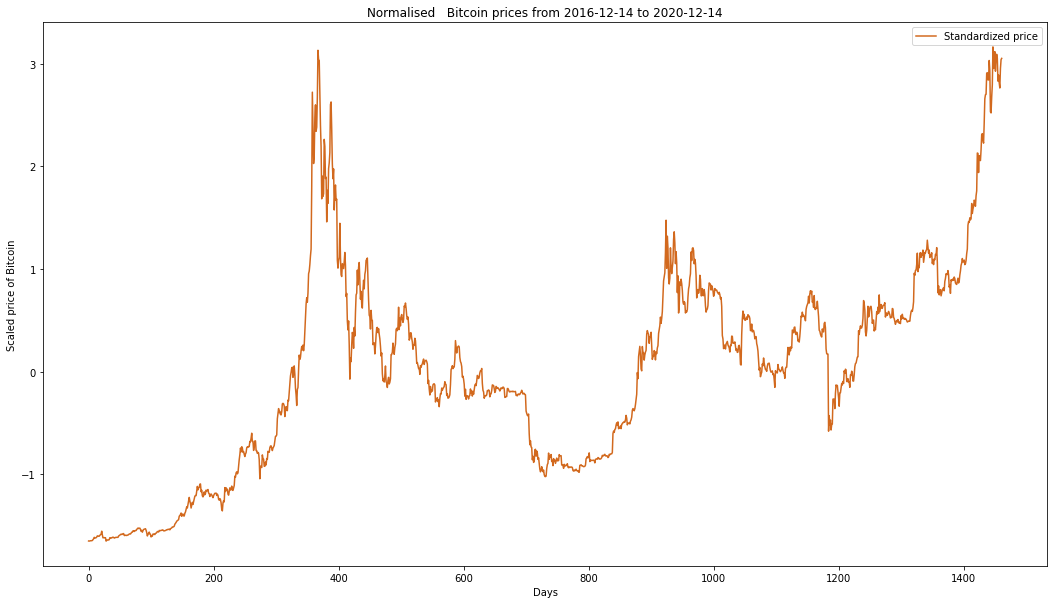

max:  [3.16485135]   min: [-1.65324475]  mean:  7.776117491218607e-17

Scaled data (10 values):

 [[-1.65229279]
 [-1.65316014]
 [-1.65141702]
 [-1.64990319]
 [-1.64997961]
 [-1.64942133]
 [-1.6473349 ]
 [-1.63879564]
 [-1.6310606 ]
 [-1.6163763 ]]


In [5]:
## data preprocessing(scaling)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_data = scaler.fit_transform(dataset.reshape(-1, 1))
print('The standardized dataset:  \n', scaled_data)
print("\nThe size of the standardized dataset is: ", scaled_data.shape)
#plotting the data
plt.figure(figsize=(18,10), frameon=False, facecolor='brown', edgecolor='blue')
plt.title('Normalised   ' + title)
plt.xlabel('Days')
plt.ylabel('Scaled price of Bitcoin')
plt.plot(scaled_data, color='chocolate', label='Standardized price')
plt.legend()
plt.show()
print("max: ", max(scaled_data), '  min:', min(scaled_data), ' mean: ', np.mean(scaled_data))
print("\nScaled data (10 values):\n\n", scaled_data[:10])

## Format and split the dataset 
Perform a series-paralell data conversion; the number of "paralell" data (windowSize) represent how many data points are used to predict the next data point. \
Example: if windowSize = 3 we are going to use 3 of the previous day to predict todays stock prices


In [6]:
# This function is used to create Features and Labels (targets) datasets; By windowing the data.
# Input: data - dataset used in the project
# window_size - how many data points we are going to use to predict the next datapoint in the sequence 
# [Example: if window_size = 1 we are going to use only the previous day to predict todays stock prices]
# Outputs: X - features splitted into windows of datapoints (if window_size = 1, X = [len(data)-1, 1])
# y - 'labels', actually this is the next number in the sequence, this number we are trying to predict

def window_data(data, window_size=7):
    X = []  # input data
    y = []  # output data (target)
    i = 0
    while (i + window_size) <= len(data) - 1:
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
        i += 1
    assert len(X) ==  len(y)
# Assertions are simply boolean expressions that checks if the conditions return true or not. 
# If it is true, the program does nothing and move to the next line of code. 
# However, if it's false, the program stops and throws an error.
# It is also a debugging tool as it brings the program on halt as soon as any error is occurred.
    return X, y
#windowing the data with window_data function

windowSize = 3
X, y = window_data(scaled_data, window_size = windowSize)
# print('\nLenght of the X list is: ', len(X))
# print("\nFirst 3 items in the X list (input)\n\n", X[:3]) # print the first 3 items in the X list
# print("\nFirst 3 items in the y list (output, target)\n\n", y[:3]) # print the first 3 items of y list

# Split the data into training and test set; not random
trainSize = 1000
X_train  = np.array(X[:trainSize])
y_train = np.array(y[:trainSize])

X_test = np.array(X[trainSize:])
y_test = np.array(y[trainSize:])

print("\nX_train size: {}".format(X_train.shape))
print("\nX_train is: ")
print("\n", X_train[:5])
print("y_train size: {}".format(y_train.shape))
print("\ny_train is: ")
print("\n", y_train[:5])

print("\nX_test size: {}".format(X_test.shape))
print("y_test size: {}".format(y_test.shape))


X_train size: (1000, 3, 1)

X_train is: 

 [[[-1.65229279]
  [-1.65316014]
  [-1.65141702]]

 [[-1.65316014]
  [-1.65141702]
  [-1.64990319]]

 [[-1.65141702]
  [-1.64990319]
  [-1.64997961]]

 [[-1.64990319]
  [-1.64997961]
  [-1.64942133]]

 [[-1.64997961]
  [-1.64942133]
  [-1.6473349 ]]]
y_train size: (1000, 1)

y_train is: 

 [[-1.64990319]
 [-1.64997961]
 [-1.64942133]
 [-1.6473349 ]
 [-1.63879564]]

X_test size: (459, 3, 1)
y_test size: (459, 1)


# RNN ahitecture

## Define the sequential model

The Sequential model of our partially generated my_RNN model:

Model: "my_RNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 LSTM_1 (LSTM)               (None, 3, 256)            264192    
                                                                 
 dropout (Dropout)           (None, 3, 256)            0         
                                                                 
 LSTM_2 (LSTM)               (None, 3, 512)            1574912   
                                                                 
 dropout_1 (Dropout)         (None, 3, 512)            0         
                                                                 
 LSTM_3 (LSTM)               (None, 512)               2099200   
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                               

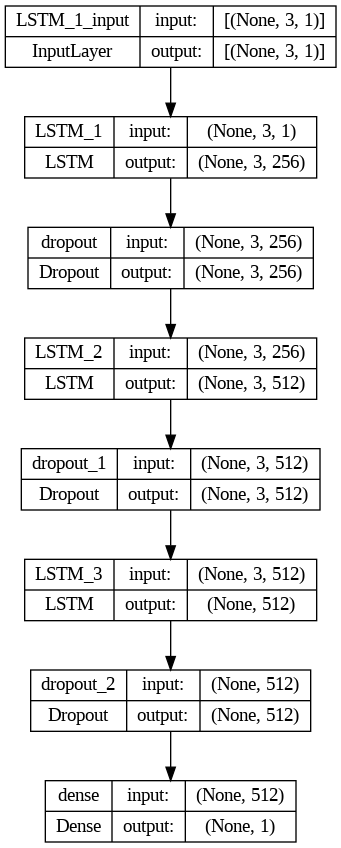

In [7]:
## define a sequential model
my_RNN = Sequential (name='my_RNN') # sequential model
## add layers
# Keras LSTM:  https://keras.io/api/layers/recurrent_layers/lstm/
my_RNN.add(LSTM(units=256, return_sequences=True, input_shape = (X_train.shape[1], X_train.shape[2]), name='LSTM_1'))
my_RNN.add(Dropout(0.25))
my_RNN.add(LSTM(units=512, return_sequences=True, name='LSTM_2'))
my_RNN.add(Dropout(0.25))
my_RNN.add(LSTM(units=512, return_sequences=False, activation=None, name='LSTM_3'))
my_RNN.add(Dropout(0.25))
my_RNN.add(Dense(units=y_train.shape[1], activation=None))

## display our  model 
print("The Sequential model of our partially generated my_RNN model:\n")
my_RNN.summary()
## plot the model graph
print("\nThe graph of our partially generated my_RNN model:\n")
plot_model(my_RNN, to_file='my_CNN_plot.png', show_shapes=True, show_layer_names=True)


## Compile and train the RNN model

In [ ]:
## compile the model
opt = tf.keras.optimizers.Adam(learning_rate=0.00007) # default is 0.001 # define the optimizer

my_RNN.compile(optimizer = opt,                     # optimiser = 'adam'
               loss ='mse',
               metrics ='mape'
               )

## train the model
max_epochs = 150
hist = my_RNN.fit(X_train, y_train,
                  epochs = max_epochs,
                  validation_data = (X_test, y_test),
                  batch_size = 32,
                  verbose = 1,
                  shuffle = True);

Epoch 1/150
32/32 [==============================] - 15s 96ms/step - loss: 0.8618 - mape: 96.5919 - val_loss: 0.8230 - val_mape: 163.3855
Epoch 2/150
32/32 [==============================] - 1s 36ms/step - loss: 0.3522 - mape: 89.3417 - val_loss: 0.1819 - val_mape: 328.3449
Epoch 3/150
32/32 [==============================] - 1s 34ms/step - loss: 0.0492 - mape: 64.2277 - val_loss: 0.0210 - val_mape: 72.4120
Epoch 4/150
32/32 [==============================] - 1s 32ms/step - loss: 0.0230 - mape: 38.5483 - val_loss: 0.0192 - val_mape: 82.5293
Epoch 5/150
32/32 [==============================] - 1s 28ms/step - loss: 0.0241 - mape: 38.1228 - val_loss: 0.0234 - val_mape: 80.5679
Epoch 6/150
32/32 [==============================] - 1s 37ms/step - loss: 0.0236 - mape: 37.6644 - val_loss: 0.0207 - val_mape: 91.6258
Epoch 7/150
32/32 [==============================] - 2s 58ms/step - loss: 0.0232 - mape: 37.4650 - val_loss: 0.0184 - val_mape: 94.2917
Epoch 8/150
32/32 [==========================

## Evaluate the CNN model

In [ ]:
# list all data in history
print(hist.history.keys())

In [ ]:
# plot loss values for training set and for validation set
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13,5))  # 1 row; 2 cols
fig.suptitle('Loss and accuracy during training')

ax1.plot(hist.history['loss']) # extract the loss values from the history object generated in the training phase
ax1.plot(hist.history['val_loss'])
ax1.set_title('Model loss during training') 
ax1.set_ylabel('Loss')
ax1.set_xlabel('Epoch') 
ax1.legend(['Train', 'Validation'], loc='upper right') 

ax2.plot(hist.history['mape'])
ax2.plot(hist.history['val_mape'])
ax2.set_title('Model  mean absolute percentage error')
ax2.set_ylabel('mape')
ax2.set_xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='lower right')
plt.show()


test_loss, test_mape = my_RNN.evaluate(X_test,  y_test, verbose=2)
print("Accuracy in the test data: ", test_mape)

## Predict

In [ ]:
## use my_RNN model to predict for the training set
y_train_pred = my_RNN.predict(X_train)

#plotting the data
plt.figure(figsize=(18,10), frameon=False, facecolor='brown', edgecolor='blue')
plt.title(' Bitcoin price - training data ')
plt.xlabel('Days')
plt.ylabel('Bitcoin price')
plt.plot(y_train, 'b.', label='Actual price')
plt.plot(y_train_pred, color='magenta', label='Predcited price')
plt.legend()
plt.show()

In [ ]:
## use my_RNN model to predict for the training set
y_test_pred = my_RNN.predict(X_test)

#plotting the data
plt.figure(figsize=(18,10), frameon=False, facecolor='brown', edgecolor='blue')
plt.title(' Bitcoin price - training data ')
plt.xlabel('Days')
plt.ylabel('Bitcoin price')
plt.plot(y_test, 'b.', label='Actual price')
plt.plot(y_test_pred, color='magenta', label='Predcited price')
plt.legend()
plt.show()